## Package

In [2]:
!pip install fastai -Uqq

     |████████████████████████████████| 213 kB 5.0 MB/s 
     |████████████████████████████████| 61 kB 9.4 MB/s 


In [3]:
from fastai.vision.all import *

## Fastai Learner from Scratch

### Data

In [4]:
path = untar_data(URLs.IMAGENETTE_160)

In [5]:
t = get_image_files(path)
t[0]

Path('/root/.fastai/data/imagenette2-160/train/n03888257/n03888257_20624.JPEG')

In [6]:
from glob import glob

files = L(glob(f'{path}/**/*.JPEG', recursive=True)).map(Path)

In [7]:
files[0]

Path('/root/.fastai/data/imagenette2-160/train/n03888257/n03888257_20624.JPEG')

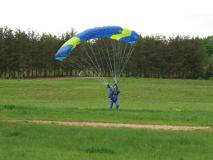

In [8]:
im = Image.open(files[0])
im

In [9]:
im_t = tensor(im)

im_t.shape

torch.Size([160, 213, 3])

In [10]:
lbls = files.map(Self.parent.name()).unique() 
lbls

(#10) ['n03888257','n03394916','n01440764','n03000684','n03028079','n02979186','n03417042','n03445777','n03425413','n02102040']

In [11]:
v2i = lbls.val2idx()
v2i

{'n01440764': 2,
 'n02102040': 9,
 'n02979186': 5,
 'n03000684': 3,
 'n03028079': 4,
 'n03394916': 1,
 'n03417042': 6,
 'n03425413': 8,
 'n03445777': 7,
 'n03888257': 0}

#### Dataset

In [12]:
class Dataset:

  def __init__(self, fns):
    self.fns = fns
  
  def __len__(self):
    return len(self.fns)

  def __getitem__(self, i):
    im = Image.open(self.fns[i]).resize((64, 65)).convert("RGB")
    y = v2i[self.fns[i].parent.name]
    return tensor(im).float()/255, tensor(y)

In [13]:
train_filt = L(o.parent.parent.name=='train' for o in files)
train,valid = files[train_filt],files[~train_filt]
len(train),len(valid)

(9469, 3925)

In [14]:
train_ds, valid_ds = Dataset(train), Dataset(valid)
x,y = train_ds[0]
x.shape, y

(torch.Size([65, 64, 3]), tensor(0))

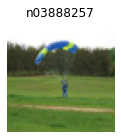

In [15]:
show_image(x, title=lbls[y]);

In [16]:
def collate(idxs, ds):
  xb, yb = zip(*[ds[i] for i in idxs])
  return torch.stack(xb), torch.stack(yb)

In [17]:
x, y = collate([1,2], train_ds)
x.shape, y

(torch.Size([2, 65, 64, 3]), tensor([0, 0]))

In [18]:
class DataLoader:
  def __init__(self, ds, bs = 128, shuffle = False, n_workers = 1):
    self.ds,self.bs,self.shuffle,self.n_workers = ds,bs,shuffle,n_workers
  
  def __len__(self): 
    return (len(self.ds)-1)//self.bs+1

  def __iter__(self):
    idxs = L.range(self.ds)
    if self.shuffle: 
      idxs = idxs.shuffle()
    
    chunks = [idxs[n: n+self.bs] for n in range(0, len(self.ds), self.bs)]

    with ProcessPoolExecutor(self.n_workers) as ex:
            yield from ex.map(collate, chunks, ds=self.ds)

In [19]:
n_workers = min(16, defaults.cpus)
train_dl = DataLoader(train_ds, bs=128, shuffle=True, n_workers=n_workers)
valid_dl = DataLoader(valid_ds, bs=256, shuffle=False, n_workers=n_workers)
xb,yb = first(train_dl)
xb.shape,yb.shape,len(train_dl)

(torch.Size([128, 65, 64, 3]), torch.Size([128]), 74)

In [20]:
stats = [xb.mean((0,1,2)),xb.std((0,1,2))]
stats

[tensor([0.4653, 0.4636, 0.4268]), tensor([0.2764, 0.2742, 0.2985])]

In [21]:
class Normalize:
    def __init__(self, stats): self.stats=stats
    def __call__(self, x):
        if x.device != self.stats[0].device:
            self.stats = to_device(self.stats, x.device)
        return (x-self.stats[0])/self.stats[1]

In [22]:
norm = Normalize(stats)
def tfm_x(x): return norm(x).permute((0,3,1,2))

In [23]:
t = tfm_x(x)
t.mean((0,2,3)),t.std((0,2,3))

(tensor([0.7462, 0.6475, 0.6818]), tensor([0.7935, 0.8622, 0.8804]))

### Module and Parameter

In [24]:
class Parameter(Tensor):
    def __new__(self, x): return Tensor._make_subclass(Parameter, x, True)
    def __init__(self, *args, **kwargs): self.requires_grad_()

In [25]:
Parameter(tensor(3.))

tensor(3., requires_grad=True)

In [26]:
class Module:
    def __init__(self):
        self.hook,self.params,self.children,self._training = None,[],[],False
        
    def register_parameters(self, *ps): self.params += ps
    def register_modules   (self, *ms): self.children += ms
        
    @property
    def training(self): return self._training
    @training.setter
    def training(self,v):
        self._training = v
        for m in self.children: m.training=v
            
    def parameters(self):
        return self.params + sum([m.parameters() for m in self.children], [])

    def __setattr__(self,k,v):
        super().__setattr__(k,v)
        if isinstance(v,Parameter): self.register_parameters(v)
        if isinstance(v,Module):    self.register_modules(v)
        
    def __call__(self, *args, **kwargs):
        res = self.forward(*args, **kwargs)
        if self.hook is not None: self.hook(res, args)
        return res
    
    def cuda(self):
        for p in self.parameters(): p.data = p.data.cuda()

In [27]:
class ConvLayer(Module):
    def __init__(self, ni, nf, stride=1, bias=True, act=True):
        super().__init__()
        self.w = Parameter(torch.zeros(nf,ni,3,3))
        self.b = Parameter(torch.zeros(nf)) if bias else None
        self.act,self.stride = act,stride
        init = nn.init.kaiming_normal_ if act else nn.init.xavier_normal_
        init(self.w)
    
    def forward(self, x):
        x = F.conv2d(x, self.w, self.b, stride=self.stride, padding=1)
        if self.act: x = F.relu(x)
        return x

In [28]:
l = ConvLayer(3, 4)
len(l.parameters())

2

In [29]:
xbt = tfm_x(xb)
r = l(xbt)
r.shape

torch.Size([128, 4, 65, 64])

In [30]:
class Linear(Module):
    def __init__(self, ni, nf):
        super().__init__()
        self.w = Parameter(torch.zeros(nf,ni))
        self.b = Parameter(torch.zeros(nf))
        nn.init.xavier_normal_(self.w)
    
    def forward(self, x): return x@self.w.t() + self.b

In [31]:
l = Linear(4,2)
r = l(torch.ones(3,4))
r.shape

torch.Size([3, 2])

In [32]:
class T(Module):
    def __init__(self):
        super().__init__()
        self.c,self.l = ConvLayer(3,4),Linear(4,2)

In [33]:
t = T()
len(t.parameters())

4

In [34]:
t.cuda()
t.l.w.device

device(type='cuda', index=0)

### Simple CNN

In [35]:
class Sequential(Module):
    def __init__(self, *layers):
        super().__init__()
        self.layers = layers
        self.register_modules(*layers)

    def forward(self, x):
        for l in self.layers: x = l(x)
        return x

In [36]:
class AdaptivePool(Module):
    def forward(self, x): return x.mean((2,3))

In [37]:
def simple_cnn():
    return Sequential(
        ConvLayer(3 ,16 ,stride=2), #32
        ConvLayer(16,32 ,stride=2), #16
        ConvLayer(32,64 ,stride=2), # 8
        ConvLayer(64,128,stride=2), # 4
        AdaptivePool(),
        Linear(128, 10)
    )

In [38]:
m = simple_cnn()
len(m.parameters())

10

In [39]:
def print_stats(outp, inp): print (outp.mean().item(),outp.std().item())
for i in range(4): m.layers[i].hook = print_stats

r = m(xbt)
r.shape

0.4921799898147583 0.733376681804657
0.40948614478111267 0.7211884260177612
0.36077043414115906 0.6135347485542297
0.271162748336792 0.4825935363769531


torch.Size([128, 10])

### Loss

In [40]:
def nll(input, target): 
  return -input[range(target.shape[0]), target].mean()

In [41]:
def log_softmax(x): 
  return (x.exp()/(x.exp().sum(-1,keepdim=True))).log()

sm = log_softmax(r); sm[0][0]

tensor(-3.7084, grad_fn=<AliasBackward0>)

In [42]:
loss = nll(sm, yb)
loss

tensor(2.4400, grad_fn=<AliasBackward0>)

In [43]:
def log_softmax(x): return x - x.exp().sum(-1,keepdim=True).log()
sm = log_softmax(r); sm[0][0]

tensor(-3.7084, grad_fn=<AliasBackward0>)

In [44]:
x = torch.rand(5)
a = x.max()
x.exp().sum().log() == a + (x-a).exp().sum().log()

tensor(True)

In [45]:
def logsumexp(x):
    m = x.max(-1)[0]
    return m + (x-m[:,None]).exp().sum(-1).log()

logsumexp(r)[0]

tensor(2.3323, grad_fn=<AliasBackward0>)

In [46]:
def log_softmax(x): return x - x.logsumexp(-1,keepdim=True)

In [47]:
sm = log_softmax(r); sm[0][0]

tensor(-3.7084, grad_fn=<AliasBackward0>)

In [48]:
def cross_entropy(preds, yb): return nll(log_softmax(preds), yb).mean()

### Learner

In [55]:
class SGD:
    def __init__(self, params, lr, wd=0.): store_attr()
    def step(self):
        for p in self.params:
            p.data -= (p.grad.data + p.data*self.wd) * self.lr
            p.grad.data.zero_()

In [56]:
class DataLoaders:
    def __init__(self, *dls): self.train,self.valid = dls

dls = DataLoaders(train_dl,valid_dl)

In [57]:
class Learner:
    def __init__(self, model, dls, loss_func, lr, cbs, opt_func=SGD):
        store_attr()
        for cb in cbs: cb.learner = self

    def one_batch(self):
        self('before_batch')
        xb,yb = self.batch
        self.preds = self.model(xb)
        self.loss = self.loss_func(self.preds, yb)
        if self.model.training:
            self.loss.backward()
            self.opt.step()
        self('after_batch')

    def one_epoch(self, train):
        self.model.training = train
        self('before_epoch')
        dl = self.dls.train if train else self.dls.valid
        for self.num,self.batch in enumerate(progress_bar(dl, leave=False)):
            self.one_batch()
        self('after_epoch')
    
    def fit(self, n_epochs):
        self('before_fit')
        self.opt = self.opt_func(self.model.parameters(), self.lr)
        self.n_epochs = n_epochs
        try:
            for self.epoch in range(n_epochs):
                self.one_epoch(True)
                self.one_epoch(False)
        except CancelFitException: pass
        self('after_fit')
        
    def __call__(self,name):
        for cb in self.cbs: getattr(cb,name,noop)()

### Callbacks

In [58]:
class Callback(GetAttr): _default='learner'

In [59]:
class SetupLearnerCB(Callback):
    def before_batch(self):
        xb,yb = to_device(self.batch)
        self.learner.batch = tfm_x(xb),yb

    def before_fit(self): self.model.cuda()

In [60]:
class TrackResults(Callback):
    def before_epoch(self): self.accs,self.losses,self.ns = [],[],[]
        
    def after_epoch(self):
        n = sum(self.ns)
        print(self.epoch, self.model.training,
              sum(self.losses).item()/n, sum(self.accs).item()/n)
        
    def after_batch(self):
        xb,yb = self.batch
        acc = (self.preds.argmax(dim=1)==yb).float().sum()
        self.accs.append(acc)
        n = len(xb)
        self.losses.append(self.loss*n)
        self.ns.append(n)

In [62]:
cbs = [SetupLearnerCB(),TrackResults()]
learn = Learner(simple_cnn(), dls, cross_entropy, lr=0.1, cbs=cbs)
learn.fit(1)

0 True 2.1425863756072445 0.22547259478297602


0 False 2.0733057573646496 0.24254777070063693


In [63]:
class LRFinder(Callback):
    def before_fit(self):
        self.losses,self.lrs = [],[]
        self.learner.lr = 1e-6
        
    def before_batch(self):
        if not self.model.training: return
        self.opt.lr *= 1.2

    def after_batch(self):
        if not self.model.training: return
        if self.opt.lr>10 or torch.isnan(self.loss): raise CancelFitException
        self.losses.append(self.loss.item())
        self.lrs.append(self.opt.lr)

In [64]:
lrfind = LRFinder()
learn = Learner(simple_cnn(), dls, cross_entropy, lr=0.1, cbs=cbs+[lrfind])
learn.fit(2)

0 True 2.5238265161315874 0.12218819305100856


0 False 2.286599820859873 0.13936305732484078


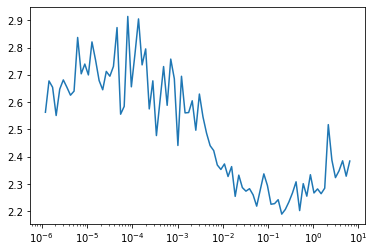

In [65]:
plt.plot(lrfind.lrs[:-2],lrfind.losses[:-2])
plt.xscale('log')

In [66]:
class OneCycle(Callback):
    def __init__(self, base_lr): self.base_lr = base_lr
    def before_fit(self): self.lrs = []

    def before_batch(self):
        if not self.model.training: return
        n = len(self.dls.train)
        bn = self.epoch*n + self.num
        mn = self.n_epochs*n
        pct = bn/mn
        pct_start,div_start = 0.25,10
        if pct<pct_start:
            pct /= pct_start
            lr = (1-pct)*self.base_lr/div_start + pct*self.base_lr
        else:
            pct = (pct-pct_start)/(1-pct_start)
            lr = (1-pct)*self.base_lr
        self.opt.lr = lr
        self.lrs.append(lr)

In [67]:
onecyc = OneCycle(0.1)
learn = Learner(simple_cnn(), dls, cross_entropy, lr=0.1, cbs=cbs+[onecyc])

In [68]:
#hide_output
learn.fit(8)

0 True 2.2213031504118703 0.17953321364452424


0 False 2.1172079020700636 0.2129936305732484


1 True 2.0596791173830393 0.25409230119336784


1 False 1.980354050557325 0.3057324840764331


2 True 1.9469124990099271 0.3146055549688457


2 False 1.9024489948248409 0.3240764331210191


3 True 1.848172944278699 0.3507234132432147


3 False 1.8155935260748408 0.37528662420382164


4 True 1.7754168206780019 0.3871580948357799


4 False 1.7737722681130572 0.3785987261146497


5 True 1.7028856292573133 0.41419368465519063


5 False 1.726393934116242 0.40738853503184713


6 True 1.6552310500052805 0.4310909282923223


6 False 1.688621989450637 0.4264968152866242


7 True 1.6101168327238884 0.4526349139296652


7 False 1.653681205214968 0.43872611464968153


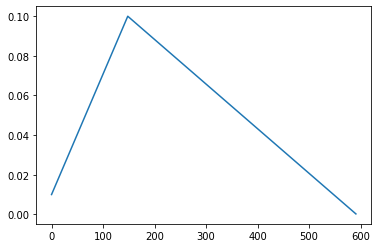

In [69]:
plt.plot(onecyc.lrs);